# Time Series Analysis and Delivery Time Impact on Review Scores

This notebook performs a time series analysis on e-commerce order data to identify trends, seasonality, and forecast future sales. Additionally, it analyzes the impact of delivery time on customer review scores.


## 1. Data Preparation

We load the dataset, convert time columns to `datetime`, filter for delivered orders, and calculate delivery time in days.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from scipy.stats import pearsonr

df = pd.read_csv('FINAL.csv')

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%m/%d/%Y %H:%M')
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], format='%m/%d/%Y %H:%M', errors='coerce')
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'], format='%m/%d/%Y %H:%M')

df = df[df['order_status'] == 'delivered']

df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

df = df.dropna(subset=['delivery_time', 'review_score'])

df_ts = df.set_index('order_purchase_timestamp')

monthly_sales = df_ts.resample('M').agg({
    'Unnamed: 0': 'count',
    'payment_value': 'sum'
}).rename(columns={'Unnamed: 0': 'order_count'})

monthly_sales.head()

<ipython-input-1-37d097736cf9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)
<ipython-input-1-37d097736cf9>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_ts.resample('M').agg({


,order_count,payment_value
order_purchase_timestamp,,
2016-09-30,3,0.00
2016-10-31,330,60844.40
2016-11-30,0,0.00
2016-12-31,1,19.62
2017-01-31,970,176887.18


## 2. Time Series Analysis: Trends and Seasonality

We perform seasonal decomposition to identify trends and seasonal patterns in the order count.

<Figure size 1200x800 with 0 Axes>

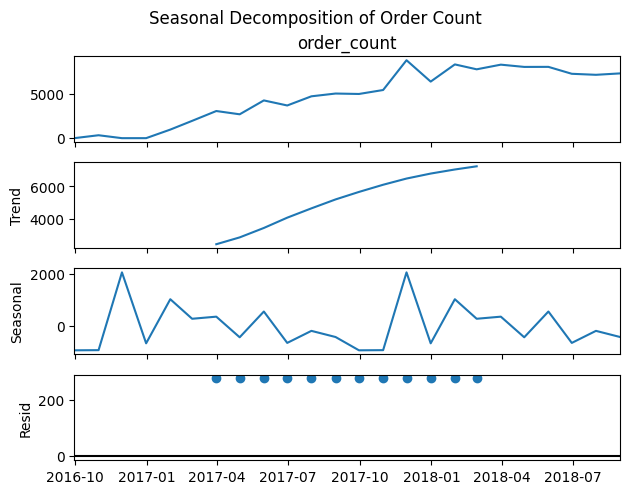

In [ ]:
decomposition = seasonal_decompose(monthly_sales['order_count'], model='additive', period=12)

plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Order Count', y=1.02)
plt.show()

## 3. Forecasting

We use an ARIMA model to forecast order counts for the next 6 months.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-3-304ab0e3a040>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='M')


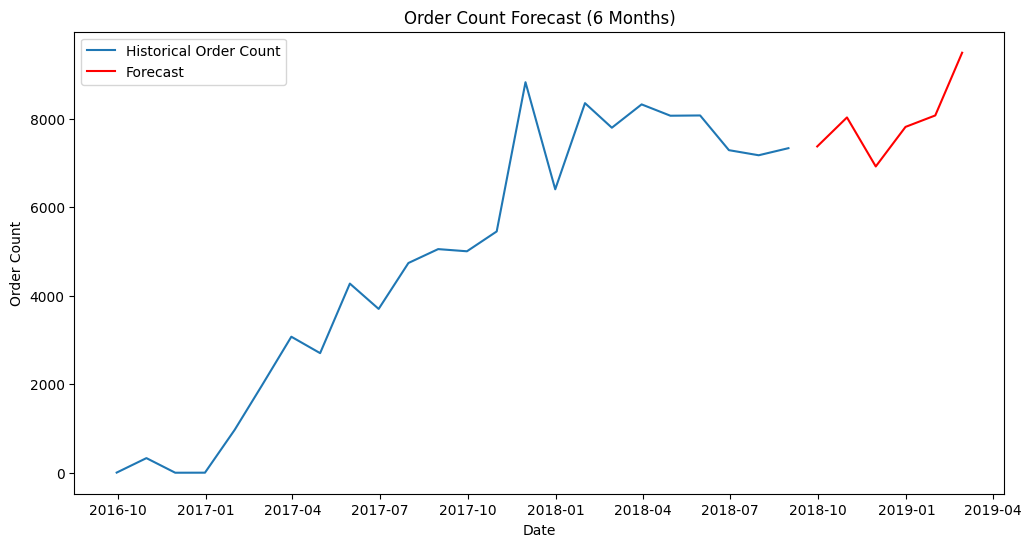

Forecasted Order Count for Next 6 Months:
2018-09-30    7369.832764
2018-10-31    8025.432019
2018-11-30    6917.949799
2018-12-31    7811.619335
2019-01-31    8070.089523
2019-02-28    9487.122082
Freq: ME, Name: predicted_mean, dtype: float64


In [ ]:
model = ARIMA(monthly_sales['order_count'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arima_result = model.fit()

forecast = arima_result.forecast(steps=6)
forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='M')

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['order_count'], label='Historical Order Count')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Order Count Forecast (6 Months)')
plt.xlabel('Date')
plt.ylabel('Order Count')
plt.legend()
plt.show()

print('Forecasted Order Count for Next 6 Months:')
print(pd.Series(forecast, index=forecast_index))

## 4. Delivery Time Impact on Review Scores

We analyze how delivery time affects review scores using correlation analysis, scatter plots, box plots, and summary statistics.

Pearson Correlation between Delivery Time and Review Score: -0.303 (p-value: 0.000)


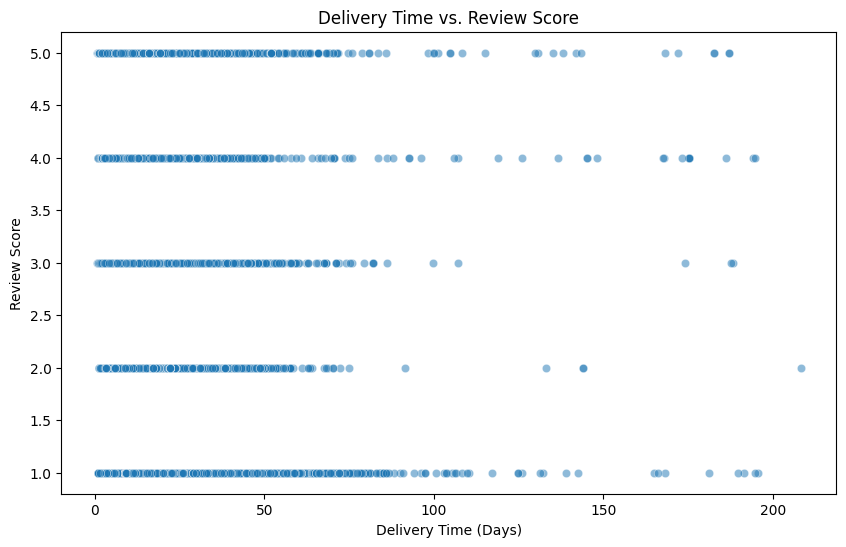

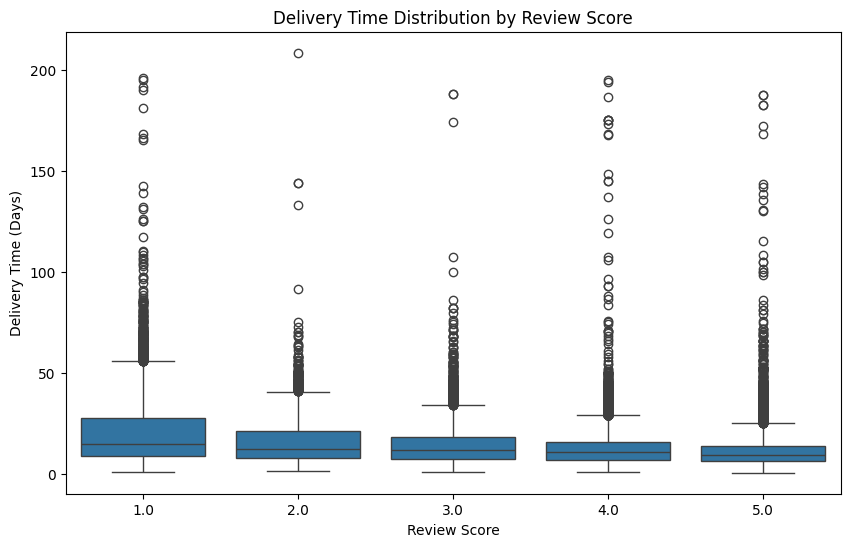


Average Delivery Time by Review Score:
review_score
1.0    19.560674
2.0    15.842278
3.0    14.016555
4.0    12.239721
5.0    10.671206
Name: delivery_time, dtype: float64


In [ ]:
corr, p_value = pearsonr(df['delivery_time'], df['review_score'])
print(f'Pearson Correlation between Delivery Time and Review Score: {corr:.3f} (p-value: {p_value:.3f})')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='delivery_time', y='review_score', data=df, alpha=0.5)
plt.title('Delivery Time vs. Review Score')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Review Score')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='delivery_time', data=df)
plt.title('Delivery Time Distribution by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (Days)')
plt.show()

avg_delivery_by_score = df.groupby('review_score')['delivery_time'].mean()
print('\nAverage Delivery Time by Review Score:')
print(avg_delivery_by_score)

## 5. Conclusions

### Time Series Analysis
- **Trends**: The seasonal decomposition shows the long-term trend in order counts, which may indicate business growth or decline.
- **Seasonality**: Peaks in certain months (e.g., November/December) suggest holiday-driven sales.
- **Forecast**: The ARIMA model provides a 6-month forecast for order counts, useful for inventory and marketing planning.

### Delivery Time Impact
- **Correlation**: A negative correlation between delivery time and review score (if observed) indicates that longer delivery times are associated with lower customer satisfaction.
- **Visualization**: The scatter and box plots highlight how delivery time varies with review scores.
- **Summary**: Average delivery times are typically higher for lower review scores, suggesting that faster delivery improves customer satisfaction.

